In [202]:
import collections
import functools
import io
import pathlib
import pickle
import random
import re
import sys

import fastai
import fastai.vision
import h5py
from IPython import display
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import png
import scipy.stats
import tqdm

In [163]:
%matplotlib inline

In [3]:
def notify(msg):
    js = f'new Notification("{msg}")'
    return display.Javascript(js)

In [4]:
path = pathlib.Path('/mnt/data1/smc_data/challenge2')

In [5]:
CbedGroupMetaData = collections.namedtuple('CbedGroupMetaData', [
    'filename',
    'groupname',
    
    'energy_keV',
    'formula',
    'material',
    'space_group',
    
    'attrs',
])

In [6]:
all_metadata = []

for filename in tqdm.tqdm(path.glob('*/*.h5')):
    with h5py.File(filename, 'r') as h5f:
        for groupname, group in h5f.items():
            attrs = dict(group.attrs)
            all_metadata.append(CbedGroupMetaData(
                filename=filename.name,
                groupname=groupname,
                
                energy_keV=attrs['energy_keV'],
                formula=attrs['formula'],
                material=attrs['material'].decode(),
                space_group=attrs['space_group'].decode(),

                attrs=attrs,
            ))

1138it [27:23,  1.44s/it]


In [439]:
attrs

{'abc_angstrom': array([5.284138e+000, 6.710794e+000, 2.534378e-314], dtype=float128),
 'angles_degree': array([8.474330e+001, 7.791030e+001, 2.534378e-314], dtype=float128),
 'd_hkls_angstrom': array([3.035360e+000, 2.991299e+000, 3.162020e-322], dtype=float128),
 'energy_keV': 190,
 'formula': 'Ca2 Cu2 Si4 O12',
 'material': b'mvc-4910',
 'semi_angles_rad': array([0.003049, 0.003094, 0.      ], dtype=float128),
 'space_group': b'15',
 'y_dirs': array([[[-1.200000e+000, -1.000000e+000,  1.000000e+000],
         [-1.000000e+000, -1.200000e+000,  3.000636e-317],
         [ 8.711254e-316,  2.404602e-314,  1.738453e-310]]], dtype=float128),
 'z_dirs': array([[[ 1,  1,  0],
         [ 2,  0,  2],
         [ 0, -2,  1]]])}

In [7]:
metadata_df = pd.DataFrame(all_metadata)

metadata_df

,filename,groupname,energy_keV,formula,material,space_group,attrs
0,batch_dev_112.h5,sample_1_0,100,K12 Fe4 O16,mp-505092,62,"{'abc_angstrom': [7.764597170000000048, 9.2551..."
1,batch_dev_112.h5,sample_1_1,110,K12 Fe4 O16,mp-505092,62,"{'abc_angstrom': [7.764597170000000048, 9.2551..."
2,batch_dev_112.h5,sample_1_2,120,K12 Fe4 O16,mp-505092,62,"{'abc_angstrom': [7.764597170000000048, 9.2551..."
3,batch_dev_112.h5,sample_1_3,130,K12 Fe4 O16,mp-505092,62,"{'abc_angstrom': [7.764597170000000048, 9.2551..."
4,batch_dev_112.h5,sample_1_4,140,K12 Fe4 O16,mp-505092,62,"{'abc_angstrom': [7.764597170000000048, 9.2551..."
...,...,...,...,...,...,...,...
187150,batch_test_122.h5,sample_5_5,150,Ca2 Cu2 Si4 O12,mvc-4910,15,"{'abc_angstrom': [5.2841380700000009085, 6.710..."
187151,batch_test_122.h5,sample_5_6,160,Ca2 Cu2 Si4 O12,mvc-4910,15,"{'abc_angstrom': [5.2841380700000009085, 6.710..."
187152,batch_test_122.h5,sample_5_7,170,Ca2 Cu2 Si4 O12,mvc-4910,15,"{'abc_angstrom': [5.2841380700000009085, 6.710..."
187153,batch_test_122.h5,sample_5_8,180,Ca2 Cu2 Si4 O12,mvc-4910,15,"{'abc_angstrom': [5.2841380700000009085, 6.710..."


In [38]:
# Skip the most popular space groups so we fit within the time budget
sorted(metadata_df['space_group'].value_counts()[20:50].index.tolist())

['122',
 '123',
 '127',
 '13',
 '136',
 '140',
 '141',
 '146',
 '160',
 '164',
 '167',
 '176',
 '186',
 '189',
 '19',
 '191',
 '230',
 '33',
 '36',
 '55',
 '58',
 '6',
 '60',
 '61',
 '64',
 '7',
 '71',
 '74',
 '88',
 '9']

In [37]:
metadata_df['space_group'].value_counts()[40:].sum() / len(metadata_df)

0.18793513397985626

In [17]:
91671 / len(metadata_df)

0.4898132563917608

# Challenge:

> Perform exploratory data analysis on both CBED patterns and materials properties to summarize data characteristics.

## What is the distribution of data?

### How much data do we have per space group?

In [406]:
file_groups = ('train', 'dev', 'test')

for file_group in file_groups:
    print(f"Group {file_group}")
    df = metadata_df[metadata_df['filename'].str.startswith(f"batch_{file_group}")]
    print(f"Number of samples:               {df.shape[0] :7,d}")
    print(f"Number of distinct formulas:     {len(df['formula'].unique()) :7,d}")
    print(f"Number of distinct space groups: {len(df['space_group'].unique()) :7,d}")

Group train
Number of samples:               148,006
Number of distinct formulas:      13,663
Number of distinct space groups:     200
Group dev
Number of samples:                20,400
Number of distinct formulas:       1,995
Number of distinct space groups:     145
Group test
Number of samples:                18,749
Number of distinct formulas:       1,844
Number of distinct space groups:     140


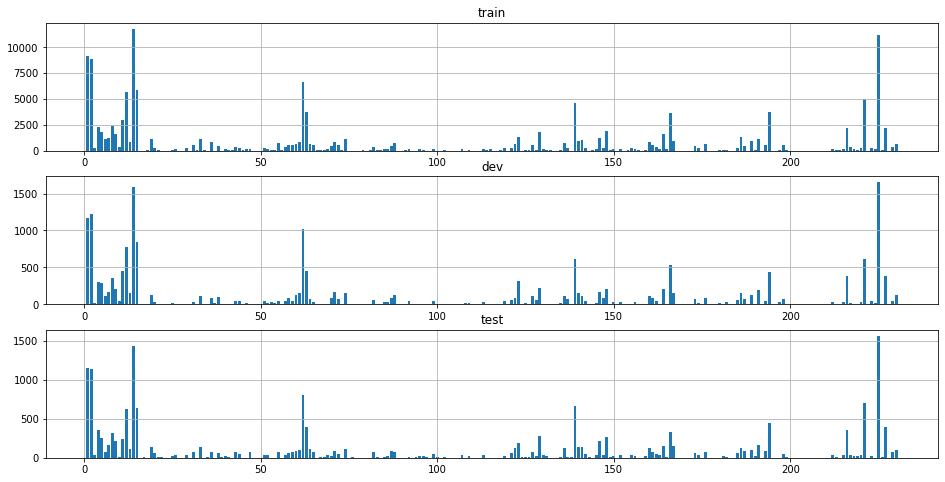

In [415]:
file_groups = ('train', 'dev', 'test')

fig, axes = plt.subplots(len(file_groups), 1, figsize=(16, 8))

for file_group, ax in zip(file_groups, axes):
    ax.set_title(file_group)
    ax.grid()
    
    xs = list(range(1, 231))
    ys = []
    
    df = metadata_df[metadata_df['filename'].str.startswith(f"batch_{file_group}")]
    for space_group in xs:
        count = len(df[df['space_group']==str(space_group)])
        ys.append(count)
    
    ax.bar(xs, ys)

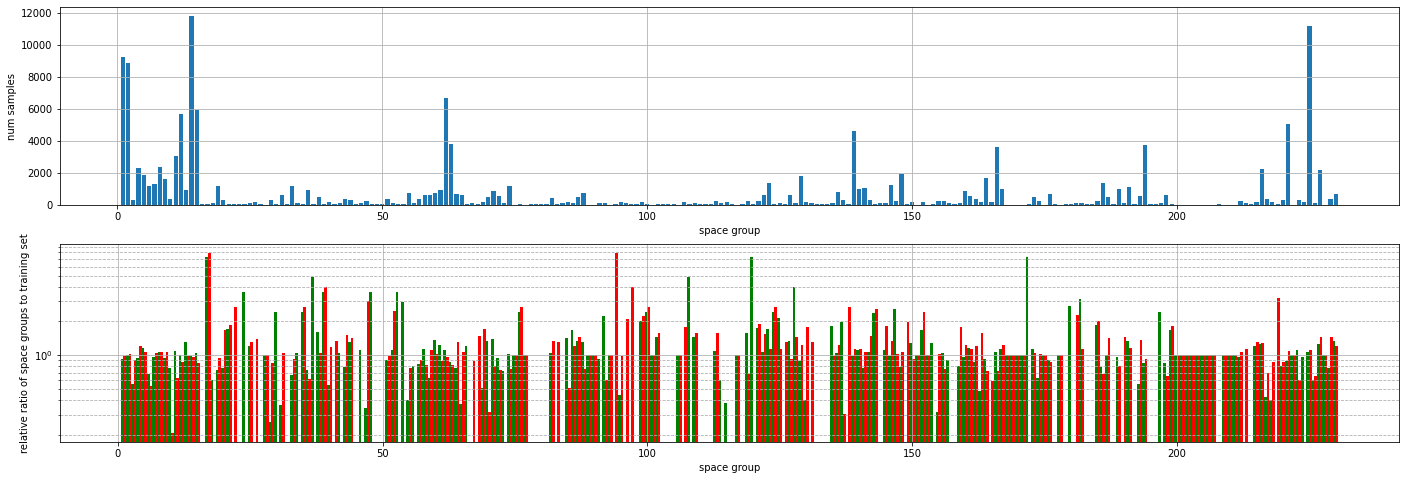

In [435]:
file_groups = ('train', 'dev', 'test')

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(24, 8))

xs = np.arange(1, 231)
ys0 = []
ys1_dev = []
ys1_test = []

train_df = metadata_df[metadata_df['filename'].str.startswith(f"batch_train")]
dev_df = metadata_df[metadata_df['filename'].str.startswith(f"batch_dev")]
test_df = metadata_df[metadata_df['filename'].str.startswith(f"batch_test")]
for space_group in xs:
    train_count = len(train_df[train_df['space_group']==str(space_group)])
    ys0.append(train_count)
    
    train_pct = train_count / len(train_df)
    dev_pct = len(dev_df[dev_df['space_group']==str(space_group)]) / len(dev_df)
    test_pct = len(test_df[test_df['space_group']==str(space_group)]) / len(test_df)
    
    if train_pct == 0:
        assert dev_pct + test_pct == 0
        ys1_dev.append(1)
        ys1_test.append(1)
        continue
    
    ys1_dev.append(dev_pct / train_pct)
    ys1_test.append(test_pct / train_pct)

ax0.bar(xs, ys0)
ax0.set_xlabel("space group")
ax0.set_ylabel("num samples")
ax0.grid()

ax1.bar(xs-0.25, ys1_dev, width=0.5, color='g')
ax1.bar(xs+0.25, ys1_test, width=0.5, color='r')
ax1.set_ylabel("relative ratio of space groups to training set")
ax1.set_xlabel("space group")
ax1.set_yscale('log')
ax1.grid()
ax1.grid(which='minor', linestyle='--')


In [106]:
space_groups = ['14', '15', '2']

train_df = metadata_df[metadata_df['filename'].str.startswith(f"batch_train")]

for space_group in space_groups:
    print(space_group, train_df[train_df['space_group']==space_group].shape)

14 (11764, 7)
15 (5911, 7)
2 (8867, 7)


In [107]:
space_groups = ['225', '221', '227', '216']

train_df = metadata_df[metadata_df['filename'].str.startswith(f"batch_train")]

for space_group in space_groups:
    print(space_group, train_df[train_df['space_group']==space_group].shape)

225 (11160, 7)
221 (5028, 7)
227 (2191, 7)
216 (2235, 7)


In [108]:
200 * 200

40000

In [103]:
metadata_df[(metadata_df['space_group']=='15')&(metadata_df['filename'].str.startswith(f"batch_train"))]

,filename,groupname,energy_keV,formula,material,space_group,attrs
20470,batch_train_86.h5,sample_1_0,100,Li2 In2 Si4 O12,mp-6240,15,"{'abc_angstrom': [5.4593137200000008136, 6.794..."
20471,batch_train_86.h5,sample_1_1,110,Li2 In2 Si4 O12,mp-6240,15,"{'abc_angstrom': [5.4593137200000008136, 6.794..."
20472,batch_train_86.h5,sample_1_2,120,Li2 In2 Si4 O12,mp-6240,15,"{'abc_angstrom': [5.4593137200000008136, 6.794..."
20473,batch_train_86.h5,sample_1_3,130,Li2 In2 Si4 O12,mp-6240,15,"{'abc_angstrom': [5.4593137200000008136, 6.794..."
20474,batch_train_86.h5,sample_1_4,140,Li2 In2 Si4 O12,mp-6240,15,"{'abc_angstrom': [5.4593137200000008136, 6.794..."
...,...,...,...,...,...,...,...
168261,batch_train_352.h5,sample_38_5,150,B4 H8 C4 O4,mp-696298,15,"{'abc_angstrom': [5.996771100000000132, 11.341..."
168262,batch_train_352.h5,sample_38_6,160,B4 H8 C4 O4,mp-696298,15,"{'abc_angstrom': [5.996771100000000132, 11.341..."
168263,batch_train_352.h5,sample_38_7,170,B4 H8 C4 O4,mp-696298,15,"{'abc_angstrom': [5.996771100000000132, 11.341..."
168264,batch_train_352.h5,sample_38_8,180,B4 H8 C4 O4,mp-696298,15,"{'abc_angstrom': [5.996771100000000132, 11.341..."


## What does a CBED stack look like?

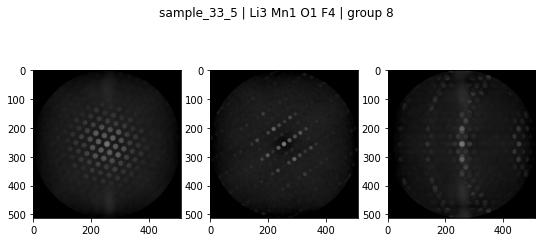

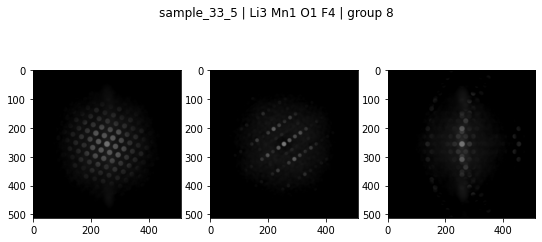

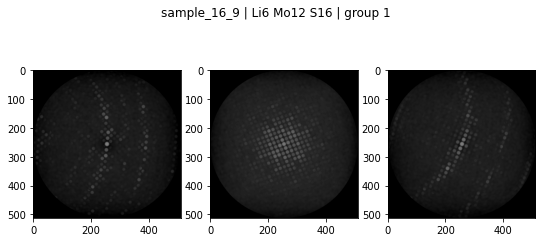

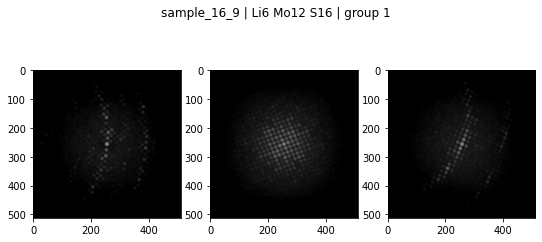

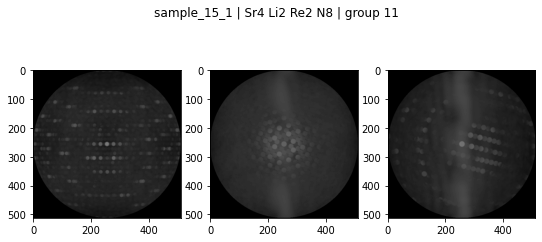

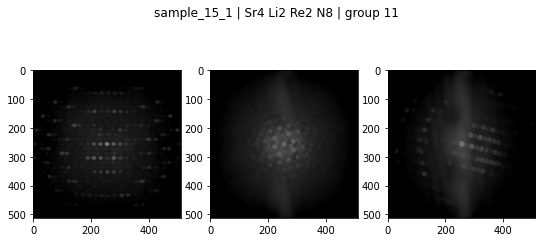

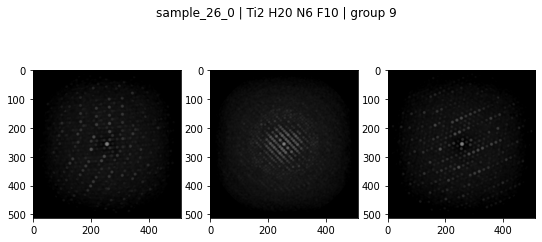

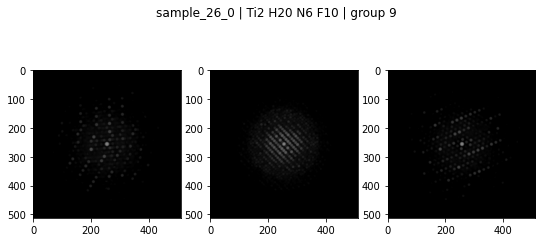

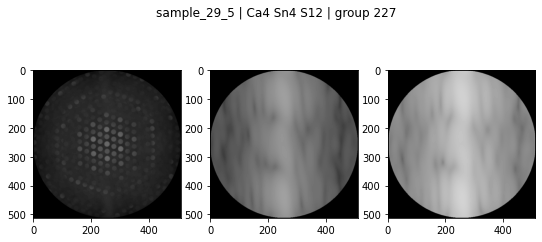

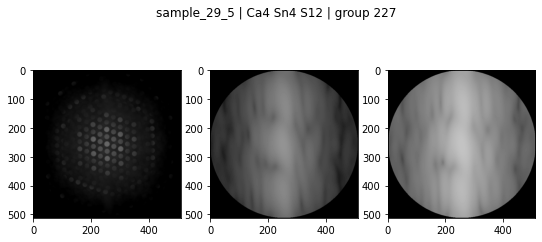

In [240]:
def plot_cbed_stack(batch_id, sample_name, scale_fn):
    filename = path/f'train/batch_train_{batch_id}.h5'
    with h5py.File(filename, 'r') as h5f:
        group = h5f[sample_name]
        assert len(group.items()) == 1
        cbed_stack = group['cbed_stack']
        assert cbed_stack.shape == (3, 512, 512)

        fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 4))
        space_group = group.attrs['space_group'].decode()
        fig.suptitle(f"{sample_name} | {group.attrs['formula']} | group {space_group}")

        cmap = 'gray'
        
        for idx, ax in enumerate((ax0, ax1, ax2)):
            scaled_img = scale_fn(group['cbed_stack'][idx])
            ax.imshow(scaled_img, cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=255))

        fig.show()

def scale_img_log(img, floor=-17):
    scaled_img = np.maximum(floor, np.log(img)) - floor
    scaled_img *= 10

    return np.clip(scaled_img, 0, 255)
    

def scale_img_poly(img):
    return img ** 0.25

def scale_middle_out(img, c=17, mult=0.5):
    log_img = np.log(img) - mult * middleout_mat
    scaled_img = np.maximum(-c, log_img) + c
    scaled_img *= 10
    return np.clip(scaled_img, 0, 255)

random.seed(10914)
h5f = h5py.File(path/'train/batch_train_0.h5', 'r')
for i in range(5):
    key = random.choice(list(h5f.keys()))
    # if i not in ( 2, ): continue
    # plot_cbed_stack('0', key, scale_middle_out2)
    plot_cbed_stack('0', key, scale_middle_out)
    # plot_cbed_stack('0', key, functools.partial(scale_middle_out, c=15.5))
    plot_cbed_stack('0', key, scale_img_log)
    # plot_cbed_stack('0', key, scale_img_poly)
    # plot_cbed_stack(h5f0, random.choice(samples_by_group[b'9']))
    # plot_cbed_stack('0', f'sample_9_{i}', scale_middle_out)

In [ ]:
# What is the distribution of intensities?

In [461]:
intensity_distribution = collections.Counter()

for filename in tqdm.tqdm(path.glob('*/*.h5')):
    with h5py.File(filename, 'r') as _h5f:
        for groupname, group in _h5f.items():
            for cbed_slice in group['cbed_stack']:
                for val in cbed_slice.astype(np.float16).flatten():
                    intensity_distribution[val] += 1
                    
len(intensity_distribution), sys.getsizeof(intensity_distribution)

645it [10:41:56, 59.72s/it] 


KeyboardInterrupt: 

In [465]:
len(intensity_distribution)

31745

In [473]:
intensity_distribution = dict(intensity_distribution)

for k, v in intensity_distribution.items():
    if v == 0:
        print(k)

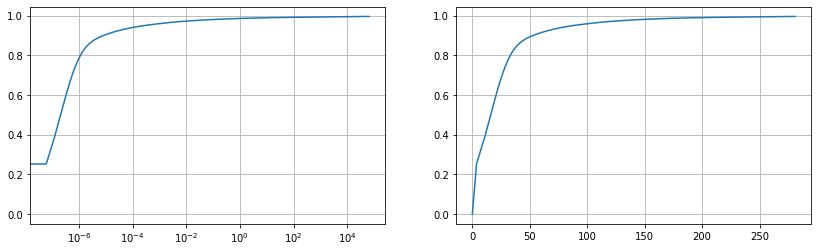

In [520]:
keys = sorted(intensity_distribution.keys())

xs = []
cdf_ys = []
cumsum = 0
total = sum(intensity_distribution.values())

def transform(x):
    if x == 0:
        return 0
    c = -17
    return 10 * (max(c, math.log(x)) -c)

for k in keys:
    xs.append(transform(k))
    
    if k == 0.0:
        intensity_distribution[k] - ((1-math.pi/4) * total)
    else:
        cumsum += intensity_distribution[k]
        
    cdf_ys.append(cumsum)
    
cdf_ys = np.array(cdf_ys) / cumsum

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))

ax0.set_xscale('log')
ax0.plot(keys, cdf_ys)
ax0.grid()

ax1.plot(xs, cdf_ys)
ax1.grid()

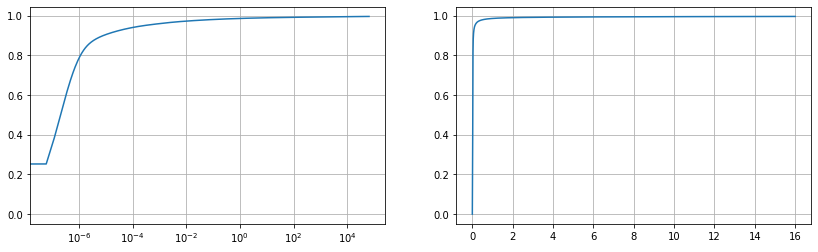

In [521]:
keys = sorted(intensity_distribution.keys())

xs = []
cdf_ys = []
cumsum = 0
total = sum(intensity_distribution.values())

def transform(x):
    return x ** 0.25

for k in keys:
    xs.append(transform(k))
    
    if k == 0.0:
        intensity_distribution[k] - ((1-math.pi/4) * total)
    else:
        cumsum += intensity_distribution[k]
        
    cdf_ys.append(cumsum)
    
cdf_ys = np.array(cdf_ys) / cumsum

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))

ax0.set_xscale('log')
ax0.plot(keys, cdf_ys)
ax0.grid()

ax1.plot(xs, cdf_ys)
ax1.grid()

0.9969486348916096

In [482]:
intensity_distribution[0.0]

40597403959

In [478]:
total

97987355973

In [476]:
for p in (10, 25, 50, 75, 90):
    k = keys[len(keys) * p // 100]
    print(k, intensity_distribution[k])

0.0002685 429716
0.006836 145670
1.5 63755
320.0 34057
7784.0 18099


31745

In [467]:
max(intensity_distribution.keys())

inf

In [443]:
x = next(iter(h5f.values()))['cbed_stack']

In [458]:
intensity_distribution = collections.Counter()

for groupname, group in h5f.items():
    for cbed_slice in group['cbed_stack']:
        for val in cbed_slice.astype(np.float16).flatten():
            intensity_distribution[val] += 1

len(intensity_distribution)

31745

In [463]:
sys.getsizeof(intensity_distribution)

1310832

In [345]:
middle_out_params = {
    'mat_low': mat_low,
    'mat_range': mat_range,
}

In [350]:
with open('/tmp/middle_out_params.pkl', 'wb') as f:
    pickle.dump(middle_out_params, f)

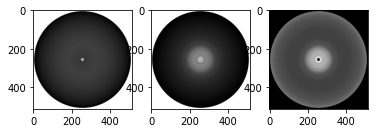

In [365]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.imshow(mat_low, cmap='gray')
ax1.imshow(mat_high, cmap='gray')
ax2.imshow(mat_range, cmap='gray')

In [307]:
mat_low.mean()

-14.76804084110559

## Scaling

> CBED data will always have orders of magnitude intensity change from the center of the image

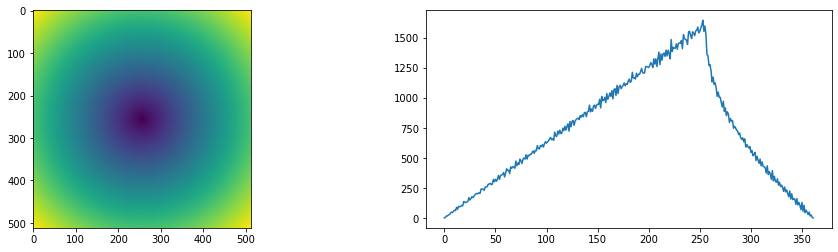

In [109]:
max_dist = 362
image_center = (511/2, 511/2)

num_samples_by_dist_per_img = np.zeros(max_dist, dtype=np.int)
img_dist_sample_idxs = []
for _ in range(max_dist):
    img_dist_sample_idxs.append([])
dist_mat = np.empty((512, 512), dtype=np.int)

for row in range(512):
    for col in range(512):
        dist_sq = (row - image_center[0]) ** 2 + (col - image_center[0]) ** 2
        dist = int(dist_sq ** 0.5)
        
        dist_mat[row][col] = dist
        num_samples_by_dist_per_img[dist] += 1
        img_dist_sample_idxs[dist].append((row, col))
        

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
ax0.imshow(dist_mat)
# ax1.plot(num_samples_by_dist_per_img)
ax1.plot([len(a) for a in  img_dist_sample_idxs])

100%|██████████| 1138/1138 [00:00<00:00, 3378.30it/s]


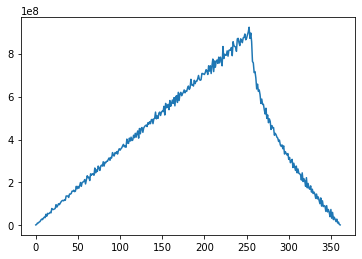

In [110]:
max_dist = 362

filenames = sorted(path.glob('*/*.h5'))
num_samples_per_file = []

for filename in tqdm.tqdm(filenames):
    with h5py.File(filename, 'r') as h5f:
        assert len(h5f) == len(h5f.values())
        
        num_samples_per_file.append(len(h5f))

total_num_samples = sum(num_samples_per_file)

num_samples_by_dist = 3 * total_num_samples * num_samples_by_dist_per_img

plt.plot(num_samples_by_dist)

In [116]:
DotDescriptor = collections.namedtuple('DotDescriptor', (
    'dist',
    'filename',  # which filename to use
    'group_offset',  # which group to use
    'sample_offset',
    'row',
    'col',
))

def idx_to_dot_descriptor(
    idx, dist,
    filenames, num_samples_per_file, num_samples_by_dist_per_img, img_dist_sample_idxs):
    
    num_samples_per_img = num_samples_by_dist_per_img[dist]
    
    # Get filename for this idx
    found = False
    for filename, num_samples in zip(filenames, num_samples_per_file):
        num_dots_in_this_file = num_samples * 3 * num_samples_per_img
        if idx < num_dots_in_this_file:
            found = True
            break
        idx -= num_dots_in_this_file
    assert found
    
    # Now idx is relative offset within this file
    group_offset = idx // (3 * num_samples_per_img)
    assert group_offset < num_samples
    
    idx = idx % (3 * num_samples_per_img)
    
    sample_offset = idx // num_samples_per_img
    idx = idx % num_samples_per_img
    
    row, col = img_dist_sample_idxs[dist][idx]
    
    return DotDescriptor(dist, filename, group_offset, sample_offset, row, col)

def get_dot(dd, h5f=None):
    h5f_was_none = h5f is None
    if h5f_was_none:
        h5f = h5py.File(dd.filename, 'r')
    
    try:
        key = sorted(h5f.keys())[dd.group_offset]
        cbed_slice = h5f[key]['cbed_stack'][dd.sample_offset]
        
        return cbed_slice[dd.row][dd.col]
        
    finally:
        if h5f_was_none:
            h5f.close()

In [138]:
dds_by_filename = collections.defaultdict(list)

for dist in tqdm.tqdm(range(max_dist)):
    idxs = random.sample(range(num_samples_by_dist[dist]), int(1e4))
    for idx in idxs:
        dd = idx_to_dot_descriptor(
            idx, dist,
            filenames, num_samples_per_file, num_samples_by_dist_per_img, img_dist_sample_idxs)

        dds_by_filename[dd.filename].append(dd)

100%|██████████| 362/362 [14:30<00:00,  2.40s/it]


In [139]:
samples_by_dist = []
for _ in range(max_dist):
    samples_by_dist.append([])

for filename, dds in tqdm.tqdm(dds_by_filename.items()):
    buf = io.BytesIO()
    with open(filename, 'rb') as f:
        buf.write(f.read())
    buf.seek(0)
    
    with h5py.File(buf, 'r') as h5f:
        for dd in dds:
            val = get_dot(dd, h5f)
            samples_by_dist[dd.dist].append(val)

100%|██████████| 1138/1138 [1:33:15<00:00,  4.92s/it] 


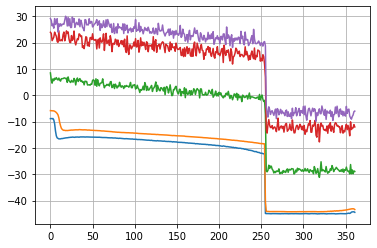

In [164]:
xs = range(max_dist)

percentiles = [1, 50, 99, 99.9, 99.99]
ys = []

for p in percentiles:
    ys.append([np.log(np.percentile(vals, p)) for vals in samples_by_dist])

fig, ax = plt.subplots()

for _ys in ys:
    ax.plot(xs, _ys)

ax.grid()

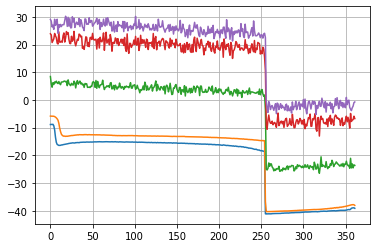

In [194]:
xs = range(max_dist)

percentiles = [1, 50, 99, 99.9, 99.99]
ys = []

for p in percentiles:
    _ys = [np.log(np.percentile(vals, p)) for vals in samples_by_dist]
    _ys -= 0.5 * avg_slope * np.arange(max_dist)
    ys.append(_ys)

fig, ax = plt.subplots()

for _ys in ys:
    ax.plot(xs, _ys)

ax.grid()

In [185]:
xs = list(range(255))

slopes = []

for p in (1, 10, 25, 50, 75, 90, 99):
    ys = [np.log(np.percentile(vals, p)) for vals in samples_by_dist[:len(xs)]]

    reg = scipy.stats.linregress(xs, ys)
    
    print(p, reg.slope)
    slopes.append(reg.slope)

avg_slope = np.mean(slopes)
print(avg_slope)

1 -0.02610822645377038
10 -0.0264711788404191
25 -0.02722080739648296
50 -0.02803426305083128
75 -0.03261578443572685
90 -0.0352144507427212
99 -0.029840256158125623
-0.029357852439725347


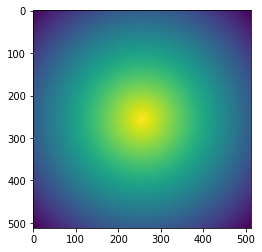

In [186]:
middleout_mat = np.zeros((512, 512))

for row in range(512):
    for col in range(512):
        dist_sq = (row - image_center[0]) ** 2 + (col - image_center[0]) ** 2
        dist = int(dist_sq ** 0.5)
        
        middleout_mat[row][col] = avg_slope * dist

plt.imshow(middleout_mat)

In [177]:
0.03 * 120

3.5999999999999996

In [ ]:
xs = 

In [ ]:
sklearn.linear_model.LinearRegression(

In [121]:
filename

PosixPath('/mnt/data1/smc_data/challenge2/test/batch_test_27.h5')

In [120]:
get_dot(dd)

1.4787342e-19

In [60]:
class RollingSampleBuffer:
    def __init__(self, buflen):
        self.buf = []
        self.buflen = buflen
        self.num_samples_seen = 0
    
    def add_sample(self, sample):
        if len(self.buf) < self.buflen:
            self.buf.append(sample)
        else:
            # replace a random element with p = buflen / (num_samples_seen + 1)
            # randint is inclusive of [0, self.num_samples_seen]
            randint = random.randint(0, self.num_samples_seen)
            if randint < self.buflen:
                self.buf[randint] = sample
            
        self.num_samples_seen += 1

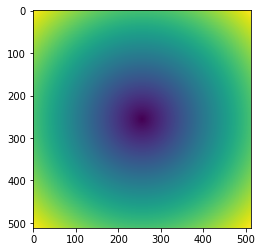

In [95]:
dist_mat = np.empty((512, 512), dtype=np.int)

image_center = (511/2, 511/2)

for row in range(512):
    for col in range(512):
        dist_sq = (row - image_center[0]) ** 2 + (col - image_center[0]) ** 2
        dist = (dist_sq ** 0.5)
        
        dist_mat[row][col] = int(dist)
        
plt.imshow(dist_mat)

In [99]:
max_dist = 362

vals_by_dist = []
for dist in range(max_dist):
    vals_by_dist.append(RollingSampleBuffer(int(1e6)))

for idx, filename in tqdm.tqdm(enumerate(path.glob('*/*.h5'))):
    with h5py.File(filename, 'r') as h5f:
        for group in h5f.values():
            for n in range(3):
                img = group['cbed_stack'][n]

                for row_idx, row in enumerate(np.log(img)):
                    for col_idx, val in enumerate(row):

                        if dist_mat[row_idx][col_idx] < max_dist:
                            vals_by_dist[dist].add_sample(val)

217it [4:20:10, 71.94s/it]


KeyboardInterrupt: 

In [ ]:
max_dist = 362
vals_by_dist_pct20 = [[] for dist in range(max_dist)]
vals_by_dist_pct80 = [[] for dist in range(max_dist)]

for idx, filename in tqdm.tqdm(enumerate(path.glob('*/*.h5'))):
    if idx >= 16: break

    with h5py.File(filename, 'r') as h5f:
        for group in h5f.values():
            for n in range(3):
                img = group['cbed_stack'][n]

                vals_by_dist = [[] for dist in range(max_dist)]

                for row_idx, row in enumerate(img):
                    for col_idx, val in enumerate(row):
                        dist_sq = (row_idx - image_center[0]) ** 2 + (col_idx - image_center[0]) ** 2
                        dist = (dist_sq ** 0.5)

                        vals_by_dist[int(dist)].append(np.log(val))

                for dist, vals in enumerate(vals_by_dist):
                    vals_by_dist_pct20[dist].append(np.percentile(vals, 20))
                    vals_by_dist_pct80[dist].append(np.percentile(vals, 80))

3it [20:24, 331.92s/it]

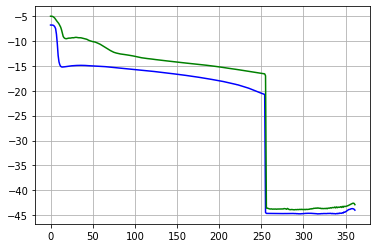

In [277]:
xs = range(max_dist)
ys20 = [np.percentile(vals, 20) for vals in vals_by_dist_pct20]
ys80 = [np.percentile(vals, 80) for vals in vals_by_dist_pct80]

fig, ax = plt.subplots()

ax.plot(xs, ys20, c='b')
ax.plot(xs, ys80, c='g')

ax.grid()

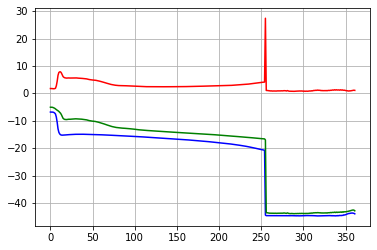

In [366]:
xs = range(max_dist)
low = np.array([np.percentile(vals, 20) for vals in vals_by_dist_pct20])
high = np.array([np.percentile(vals, 80) for vals in vals_by_dist_pct80])
rng = high - low

fig, ax = plt.subplots()

ax.plot(xs, low, c='b')
ax.plot(xs, high, c='g')
ax.plot(xs, rng, c='r')

ax.grid()

In [363]:
mat_low = np.zeros((512, 512))
mat_high = np.zeros((512, 512))
mat_range = np.zeros((512, 512))

pct20_data = [np.percentile(vals, 20) for vals in vals_by_dist_pct20]
pct80_data = [np.percentile(vals, 80) for vals in vals_by_dist_pct80]

for row_idx in tqdm.tqdm(range(512)):
    for col_idx in range(512):
        dist_sq = (row_idx - image_center[0]) ** 2 + (col_idx - image_center[0]) ** 2
        dist = int(dist_sq ** 0.5)
        
        if dist >= 250:
            mat_low[row_idx][col_idx] = 0.
            mat_high[row_idx][col_idx] = 0.
            mat_range[row_idx][col_idx] = 1.
            continue
        
        pct20 = pct20_data[dist]
        pct80 = pct80_data[dist]
        
        mid = (pct20 + pct80) / 2
        rng = (pct80 - pct20) * (1./.6)
        
        mat_low[row_idx][col_idx] = mid - rng / 2
        mat_high[row_idx][col_idx] = mid + rng / 2
        mat_range[row_idx][col_idx] = rng

100%|██████████| 512/512 [00:00<00:00, 989.50it/s] 


In [295]:
np.percentile(vals_by_dist_pct80[0], 80)

-5.0516032791137695

In [303]:
row_idx, col_idx = 256, 256

dist_sq = (row_idx - image_center[0]) ** 2 + (col_idx - image_center[0]) ** 2
dist = int(dist_sq ** 0.5)

assert dist <= 256
print(dist)

pct20 = np.percentile(vals_by_dist_pct20[dist], 20)
pct80 = np.percentile(vals_by_dist_pct80[dist], 80)

print(pct20, pct80)

mid = (pct20 + pct80) / 2
rng = (pct80 - pct20) * (1./.6)

print(mid, rng)
print(mid - rng / 2, mid + rng / 2)

0
-6.817552738189697 -5.0516032791137695
-5.934578008651734 2.943249098459879
-7.406202557881674 -4.462953459421794


In [296]:
mat_high[256][256]

18.691410433115006

In [187]:
512 / 2

256.0

In [ ]:
def scale_img_log(img):
    return np.maximum(-17, np.log(img)) + 17

In [179]:
notify('EDA done')

<IPython.core.display.Javascript object>

## There seem to be two types of cbed images, one where there is a hazy aberration, and ones without.

We may want to use separate scaling functions, depending on whether there is an aberration.

Try to make a simple classifier for whether there is an aberration, based on average luminosity of the log images

In [134]:
cutoffs = [2, 3, 4, 5, 6, 7, 8, 9, 10]

data = {
    cutoff: []
    for cutoff in cutoffs
}

In [135]:
for filename in tqdm.tqdm(path.glob('*/*.h5')):
    with h5py.File(filename, 'r') as h5f:
        for groupname, group in h5f.items():
            for n in range(3):
                img = group['cbed_stack'][n]
                scaled_img = scale_img_log(img)
                
                for cutoff in cutoffs:
                    num_lit = scaled_img[scaled_img>=cutoff].shape[0]
                    data[cutoff].append(num_lit)

194it [22:12,  6.87s/it]


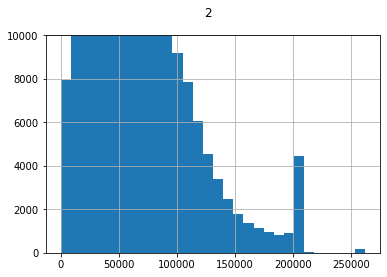

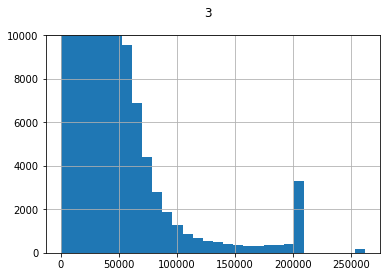

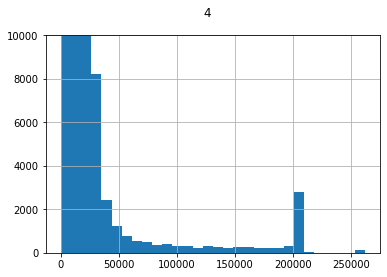

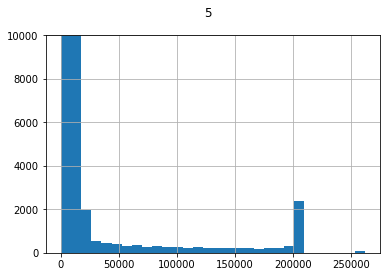

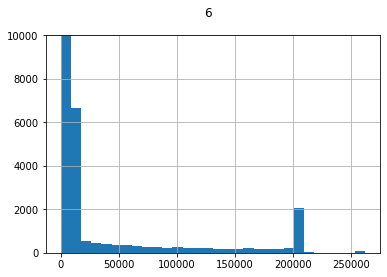

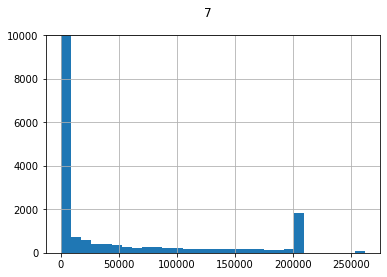

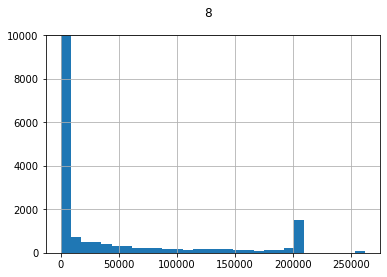

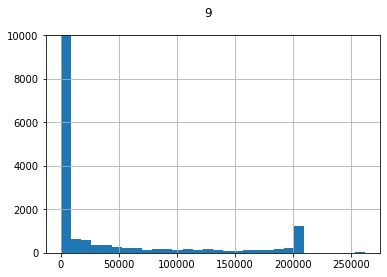

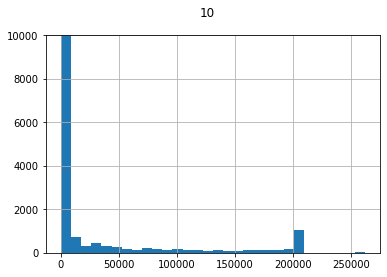

In [143]:
for cutoff in cutoffs:
    fig, ax = plt.subplots()
    fig.suptitle(cutoff)
    ax.hist(data[cutoff], bins=30)
    ax.set_ylim(0, 10000)
    ax.grid()

In [106]:
for group, _ in zip(h5f.values(), range(2)):
    for n in range(3):
        img = group['cbed_stack'][n]
        scaled_img = scale_img_log(img)
        m = scaled_img[scaled_img>2].shape[0]
        print(m)
    pass

x = scale_img_log(group['cbed_stack'][0])
x[x>2].shape

38138
22176
46666
37049
19806
41843


(37049,)